In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.cluster import KMeans

# INF 554 Lab 4: Unsupervised Learning

In Lab 3 we worked with supervised classifcation methods where training data points were labelled and we were able to use these labels to train our models. When class labels are not available to us then we utilise unsupervised learning methods, which do not rely on known class labels.

In this lab we will work with two unsupervised learning algorithms, namely the $K$-means algorithm and the Spectral Clustering algorithm. Both of these methods are known as _clustering algorithms_ because they label each data point with a discrete label corresponding to a cluster detected in the data. 




## K-means

Let $\{x_1, \dots, x_n\}$ be a set of $n$ data points. The $K$-means algorithm aims to cluster the datapoints into $K$ clusters, where the number of clusters $K$ is an input of the algorithm. The $K$-means objective function is equal to the following,
\begin{equation} \label{eq:kmeans_objective}
\underset{(C_1, \ldots, C_K)}{\text{argmin}} \sum_{j=1}^K \sum_{i \in C_j} \|x_i - c_j\|^2, \hspace{1.5cm}(1)
\end{equation}

where $\{c_1, \ldots, c_K\}$ denote the centroids of the $K$ clusters denoted $\{C_1, \ldots, C_K\}$.This objective function is solved using an iterative algorithm, where the following two steps take part at each iteration: (i) take each instance belonging  to the dataset and assign it to the nearest centroid, and (ii)  re-calculate  the centroids  of  each of the $K$  clusters. Thus, the $K$ centroids change their location step by step until no more changes are done.




In this lab we work with simulated data which is drawn from several Gaussian distributions with different means and variances. We provide you with the $\text{generate}$_$\text{data}$ function to sample this data.





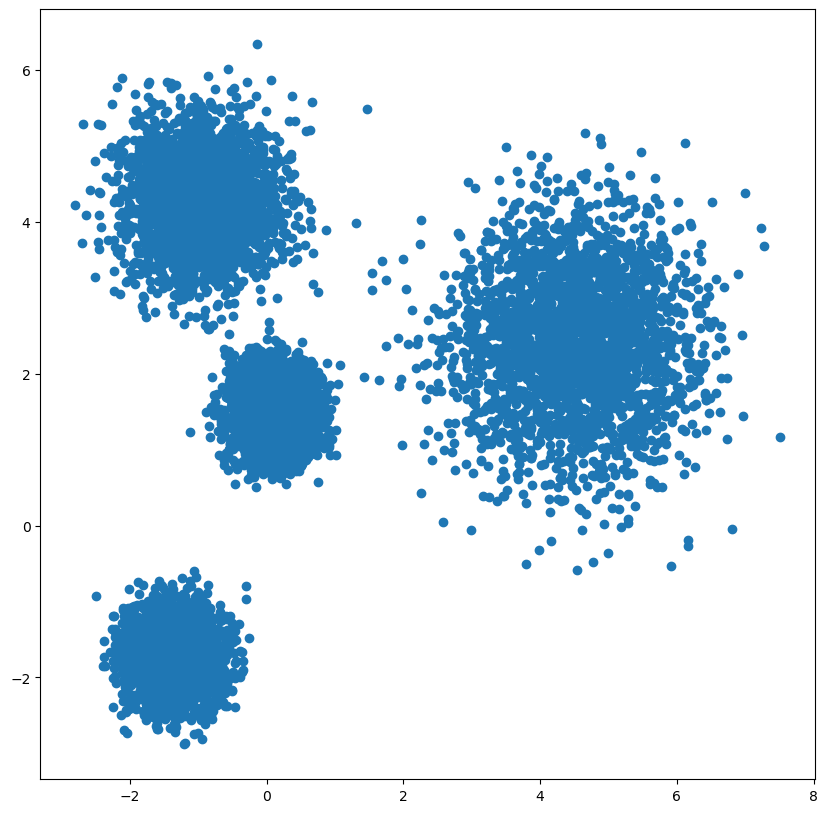

In [3]:
np.random.seed(2604)


def generate_data(n_clusters, n_dim, n_data):
    """
    Args:
        n_clusters (int): the number of clusters
        n_dim (int): data dimensionality
        n_data (int): number of data points (split evenly into clusters)
    Returns:
        X (np.array(n_data, n_dim)): data  
    """
    mus = np.random.uniform(-5, 5, size=(n_clusters,n_dim))
    sigmas = np.random.uniform(-0.7, 0.7, size=(n_clusters,n_dim))
    X = []
    for k in range(n_clusters):
        X.append(np.random.normal(mus[k,:],sigmas[k,:] @ sigmas[k,:].T,size=(int(n_data/n_clusters),n_dim)))
    return  np.concatenate([X]).reshape(-1,n_dim)


X = generate_data(n_clusters=4, n_dim=2, n_data=10000)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.show()

We will now consider two possible centroid initialisation schemes for the $K$-means algorithm. 

Firstly, in the standard $K$-means algorithm cluster centroids are initialised at random datapoints in our dataset.

Secondly, in the improved $K$-means++ algorithm the centroids are sampled one by one with the first centroid being chosen at a random data point. Further, if we let $d_i$ denote the Euclidean distance of datapoint $x_i$ to its closest, already sampled, centroid, then the probability of data point $x_i$ being chosen as the next centroid is equal to $\frac{d_i^2}{\sum_{i=1}^n d_i^2}.$ 

>**Task 1**: Implement the $K$-means++ initialisation scheme and visually compare its output with the random initialisation scheme in the below plot. (Hint: you can make use of ```np.random.multinomial``` to sample the index of the next centroid in the $K$-means++ initialisation scheme. )

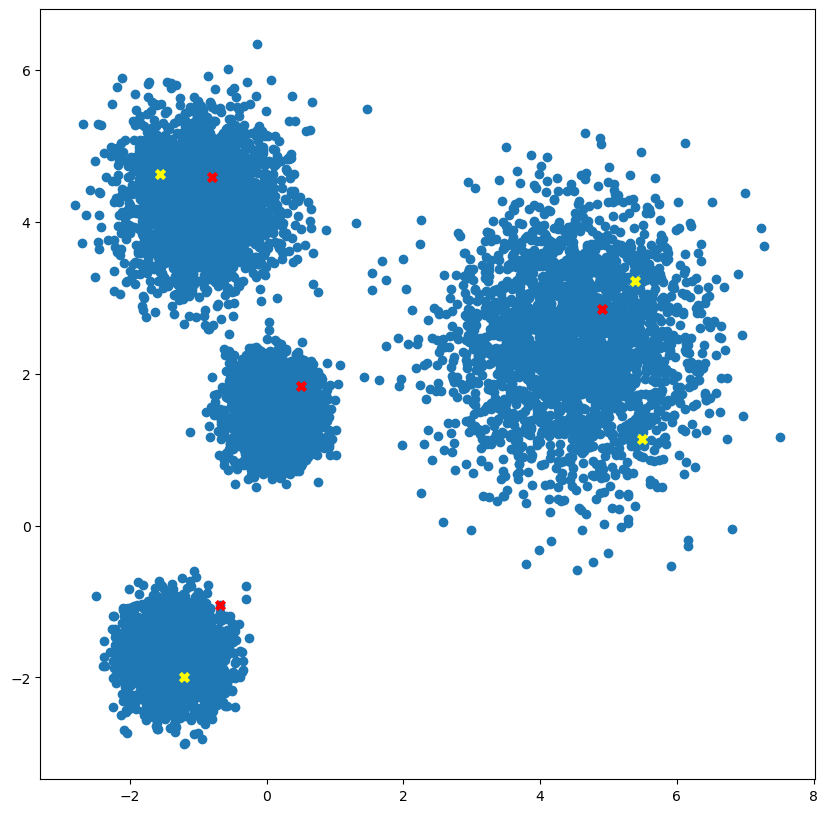

In [4]:
def random_initialisation(X,K):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
    Returns:
        c (np.array(K,d)): matrix containing the randomly initialised cluster centeres 
    """
    
    N = X.shape[0]
    
    #initialisation
    initial_indices = np.random.choice(np.arange(N), size=K, replace=False)
    c = X[initial_indices, :]
    
    return c
    

def kmeans_plusplus_initialisation(X,K):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
    Returns:
        c (np.array(K,d)): matrix containing the k-means++ initialised cluster centeres 
    """
    
    N,d = X.shape
    
    c = np.zeros((K,d))
    
    initial_index = np.random.choice(np.arange(N), size=1, replace=False)
    c[0,:] = X[initial_index, :]
    
    dist = np.zeros(N)
    for i in range(N) :
        dist[i] = np.linalg.norm(X[i, :] - c[0, :])

    for k in range(1, K) :
        proba = dist / dist.sum()
        next_index = np.random.multinomial(1, proba).argmax()
        c[k, :] = X[next_index, :]
        for i in range(N) :
            dist[i] = min(np.linalg.norm(X[i, :] - c[k, :]), dist[i])
        
    return c
        
        
c_random = random_initialisation(X,4)
c_plus_plus = kmeans_plusplus_initialisation(X,4)


plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.scatter(c_random[:,0].reshape(-1), c_random[:,1].reshape(-1), c='red', marker='x', linewidths=3)
plt.scatter(c_plus_plus[:,0].reshape(-1), c_plus_plus[:,1].reshape(-1), c='yellow', marker='x', linewidths=3)
plt.show()


>**Task 2**: Implement the $K$-means clustering algorithm.

1
2
3
4
5
6
7
8
9
10
11


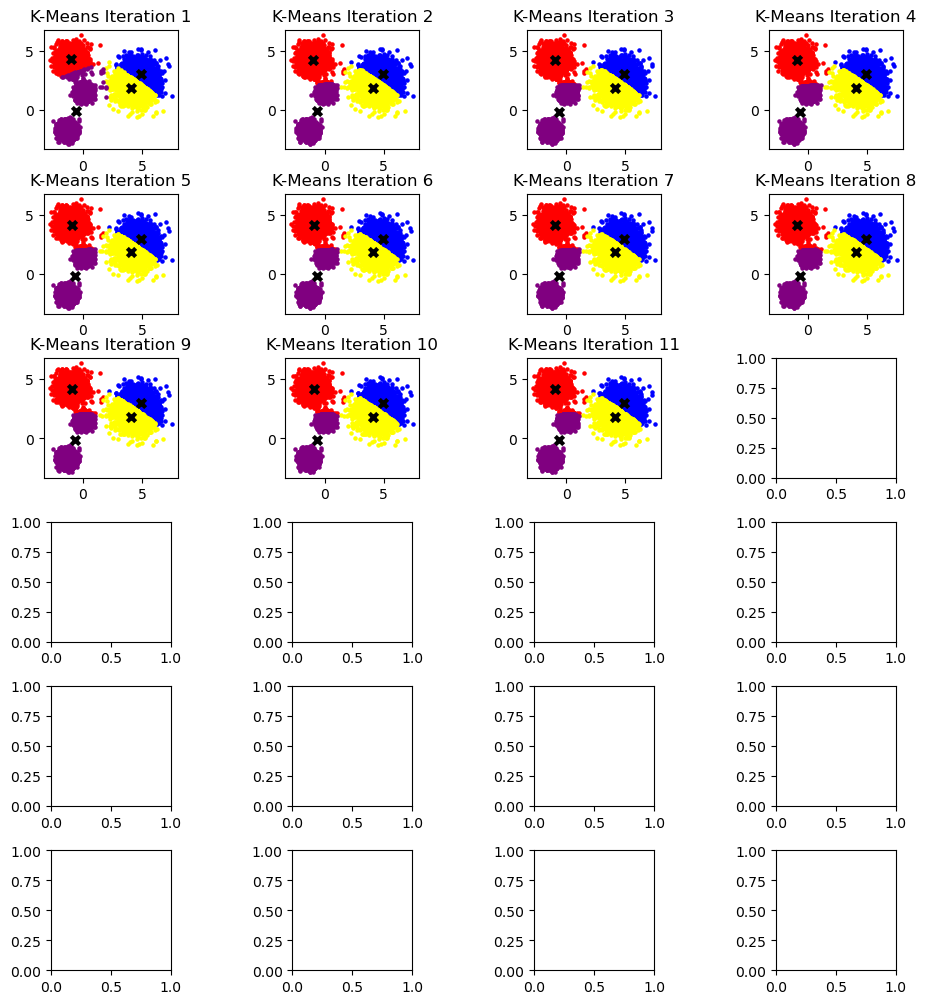

In [56]:
def plot_Kmeans(X, c, S, iteration_count_for_visualisation, a):
    clusters_col = ["red", "blue", "yellow", "purple", "black", "green", "cyan"] 
    for j in range(K):
        x1 = [X[i,0] for i in range(X.shape[0]) if S[i,j]==1]
        x2 = [X[i,1] for i in range(X.shape[0]) if S[i,j]==1]
        a[int(np.floor((iteration_count_for_visualisation-1)/4)), (iteration_count_for_visualisation-1)%4].scatter(x1,x2, c=clusters_col[j], s=5)
    a[int(np.floor((iteration_count_for_visualisation-1)/4)), (iteration_count_for_visualisation-1)%4].scatter(c[:,0].reshape(-1), c[:,1].reshape(-1), c='black', marker='x', linewidths=3)
    a[int(np.floor((iteration_count_for_visualisation-1)/4)), (iteration_count_for_visualisation-1)%4].title.set_text('K-Means Iteration ' + str(iteration_count_for_visualisation))

    
    
    
def K_means(X, K, initialisation, E=10**(-8), visualise=True):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
        E (float): acceptable margin of error for the stopping rule
        visualise (boolean): indicator of whether the progression of the k-means algorithm should be plotted
    Returns:
        c (np.array(K,d)): matrix containing the cluster centeres 
        S (np.array(N,K)): binary matrix containing 1-hot encodings of the cluster membership 
    """
    
    
    
    if initialisation == 'random':
        c = random_initialisation(X,K)
        
    elif initialisation == 'plusplus':
        c = kmeans_plusplus_initialisation(X,K)
        
    else:
        raise ValueError("Please specify a valid initialisation scheme ('random' or 'plusplus').")
    

    if visualise == True:
        fig, a = plt.subplots(nrows=6, ncols=4, subplot_kw={'aspect': 'equal'}, figsize=(10,10))
        fig.tight_layout()
    
    N = X.shape[0]
    c_temp = c+2*E
    iteration_count_for_visualisation = 1
    
    S = np.zeros((N, K))
    
    while(np.abs(np.mean(c-c_temp))>E):
        
        S = np.zeros((N, K))
        # E-step
        for i in range(N) :
            dist = np.linalg.norm((X[i, :] - c), axis=1)
            cluster_idx = dist.argmin()
            # the i th data point belongs to the cluster_idx
            S[i, cluster_idx] = 1
            
            
        # M-step
        c_temp = c
        c = (S.T @ X) / S.sum(axis = 0).reshape(-1, 1)
        
        # for k in range(K) :
        #     new_center = 0
        #     for i in clusters[k] :
        #         new_center += X[i, :]
        #     new_center /= len(clusters[k])
            
        #     # Update the center
        #     c_temp[k] = new_center
            
        
        if visualise == True:
            print(iteration_count_for_visualisation)
            plot_Kmeans(X, c, S, iteration_count_for_visualisation, a)
            iteration_count_for_visualisation += 1

    return c, S

K=4
c,S = K_means(X,K, 'random')
plt.show()

>**Task 3**: For $K\in \{1,\ldots,8\}$ please run the standard $K$-means and the $K$-means++ algorithm 10 times each and log their final objective values computed according to Equation (1). Then, for each $K$ compute the mean objective value over all 10 runs for both algorithms and plot them against the parameter $K.$ (Please store the values obtained for the standard initialisation in the first row of $\texttt{SSW}$\_$\texttt{temp}$ and the values obtained for the $K$-means++ initialisation in the second row of $\texttt{SSW}$\_$\texttt{temp}$.) 


1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9


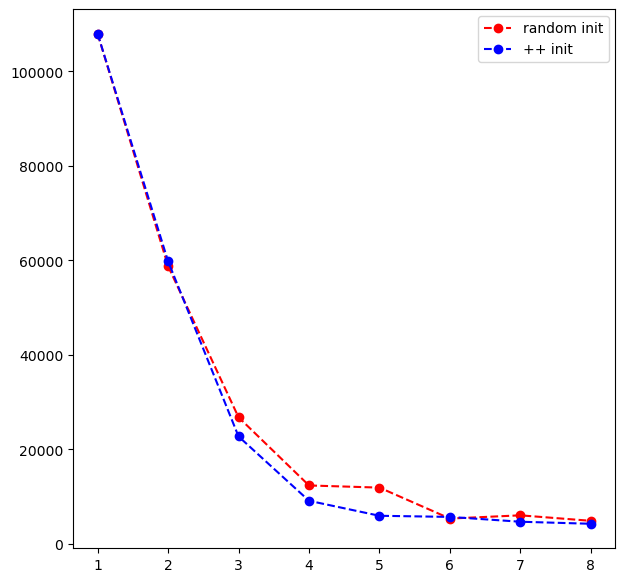

In [64]:
def Elbow(X, k_max, E, repetitions):
    """
    Args:
        X (np.array(N,d)): data. 
        k_max (int): the numbers of clusters up to which we calculate the objective function
        E (float): acceptable margin of error for the K-Means stopping rule
        repetitions (int): Number of clusterings over which we average the final objective values
    Returns:
        SSW_standard (np.array(k_max)): The average of the final objective values for the obtained clusterings
                                 of the standard K-means algorithm
        SSW_plusplus (np.array(k_max)): The average of the final objective values for the obtained clusterings
                                 of the K-means++ algorithm
    """
    
    SSW_standard = np.zeros(k_max)
    SSW_plusplus = np.zeros(k_max)
    
    for j in range(1, k_max+1):
        SSW_temp = np.zeros((2, repetitions))
        for rep in range(repetitions):
            print(j, rep)
            for i, init in enumerate(['random', 'plusplus']):
                c, S = K_means(X, j, initialisation=init, E=E, visualise=False)
                objective_function = 0
                for k in range(j) :
                    objective_function += S[:, k].T @ np.linalg.norm(X - c[k, :], axis = 1)**2 
                SSW_temp[i, rep] = objective_function
                   
        SSW_standard[j-1] = np.mean(SSW_temp[0,:])
        SSW_plusplus[j-1] = np.mean(SSW_temp[1,:])
    
    
    return SSW_standard, SSW_plusplus

K_max = 8
SSW_standard, SSW_plusplus = Elbow(X, K_max, 10**(-5), 10)

fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(K_max)+1, SSW_standard, 'o--', c='r')
plt.plot(np.arange(K_max)+1, SSW_plusplus, 'o--', c='b')
plt.legend(['random init', '++ init'])
plt.show()

>**Question 1**: Can you think of a reasonable heuristic to choose the number of clusters $K$ in the $K$-means algorithm based on  the plot created in Task 2.

>**Question 2**: In which scenarios do you think will the $K$-means algorithm fail to identify sensible clusters in clustered data.


## Spectral Clustering

We will now take a different approach to clustering. Given some data points, we will use one of several possible heuristics to infer a graph from the given data points (Task 5). We will then proceed to cluster nodes in this graph (each corresponding to a data point) using the spectral clustering algorithm (Task 6) to obtain a clustering of the data points.


### Dataset: Three Concentric Circles

We begin by generating a variation of the famous synthetic, concentric circles dataset.



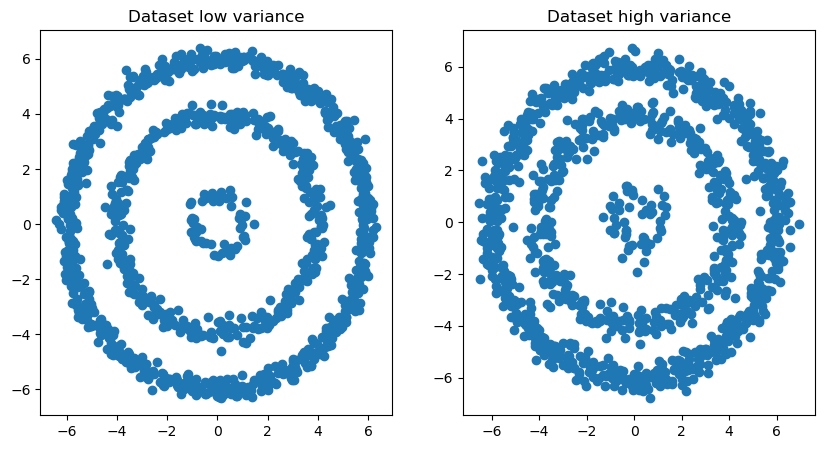

In [3]:
np.random.seed(5)

def get_circle(r=1.0, N=150):  
    # Use polar coords to get unif dist points  
    step = np.pi * 2.0 / N  
    t = np.arange(0, np.pi * 2.0, step)  
    x_1 = r * np.cos(t)  
    x_2 = r * np.sin(t)  
    return np.column_stack((x_1, x_2))
      
def get_noise(stddev=0.2, N=150):  
    # 2d gaussian random noise  
    x_1 = np.random.normal(0, stddev, N)  
    x_2 = np.random.normal(0, stddev, N)  
    return np.column_stack((x_1, x_2))    
  
def generateData(sigma):
    inner_circle = get_circle(r=1, N=50) + get_noise(sigma,N=50)
    middle_circle = get_circle(r=4, N=400) + get_noise(sigma,N=400)
    outer_circle = get_circle(r=6, N=800) + get_noise(sigma, N=800)
    return np.vstack([inner_circle, middle_circle, outer_circle])
 
 
X_low_var = generateData(0.2)

X_high_var = generateData(0.3)



# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(X_low_var[:,0], X_low_var[:,1])
ax[0].title.set_text('Dataset low variance')
ax[1].scatter(X_high_var[:,0], X_high_var[:,1])
ax[1].title.set_text('Dataset high variance')
plt.show()

>**Task 4:** Given the detailed understanding of k-means that we have gained in the first three tasks, we can now simply use the [scikit-learn kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation to cluster the two datasets using the kmeans algorithm (Note that we already loaded the KMeans function for you in code cell 1). Please store the produced labels in the two variables ```labels_low_var``` and ```labels_high_var```. Set the number of tried initialisations (```n_init```) to 10. You may assume knowledge of the true number of clusters, i.e., k=3.

c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


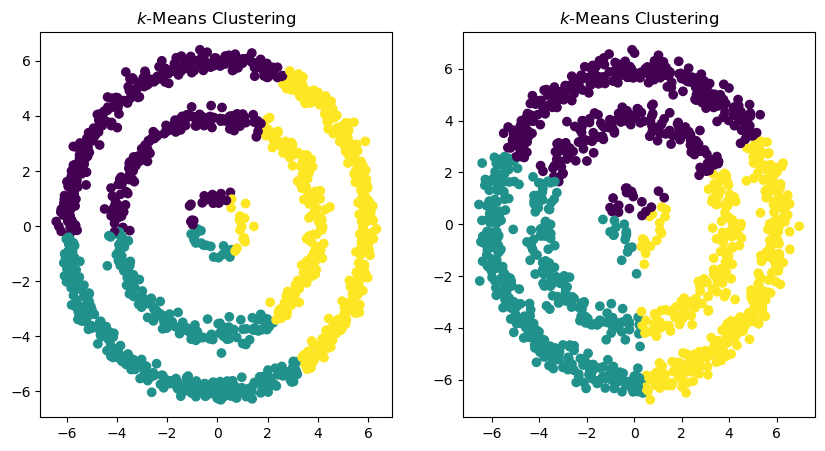

In [6]:
labels_low_var = np.zeros(X_low_var.shape[0])
labels_high_var = np.zeros(X_high_var.shape[0])

k = 3

# initiate the models
model_low_var = KMeans(n_clusters=k, n_init=10)
model_high_var = KMeans(n_clusters=k, n_init=10)

# fit the model
model_low_var.fit(X_low_var)
model_high_var.fit(X_high_var)

# get the clusters
labels_low_var = model_low_var.labels_
labels_high_var = model_high_var.labels_

# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(X_low_var[:,0], X_low_var[:,1], c=labels_low_var, facecolors="none") 
ax[0].title.set_text('$k$-Means Clustering')

ax[1].scatter(X_high_var[:,0], X_high_var[:,1], c=labels_high_var, facecolors="none") 
ax[1].title.set_text('$k$-Means Clustering')

plt.show()

We will now use two different heuristics to infer a graph from a set of data points. 


>**Task 5:** Implement the function ```knn_graph``` to construct a k-nearest neighbour graph from a set of data points (please draw an edge if either of the two data points concerned is among the k-nearest neighbours of the other).  Furthermore, fill out the ```gaussianKernel``` function to infer a weighted fully connected graph from the two datasets using the Gaussian kernel as a similarity function. (The Gaussian kernel will be discussed in greater detail in Lab 5, for now it suffices to know that it contains a free parameter $\sigma$ and is defined as follows $  K_{Gauss}(x_i, x_j) = \exp\left( - \frac{\| x_i - x_j\|^2}{2 \sigma^2}\right).$)

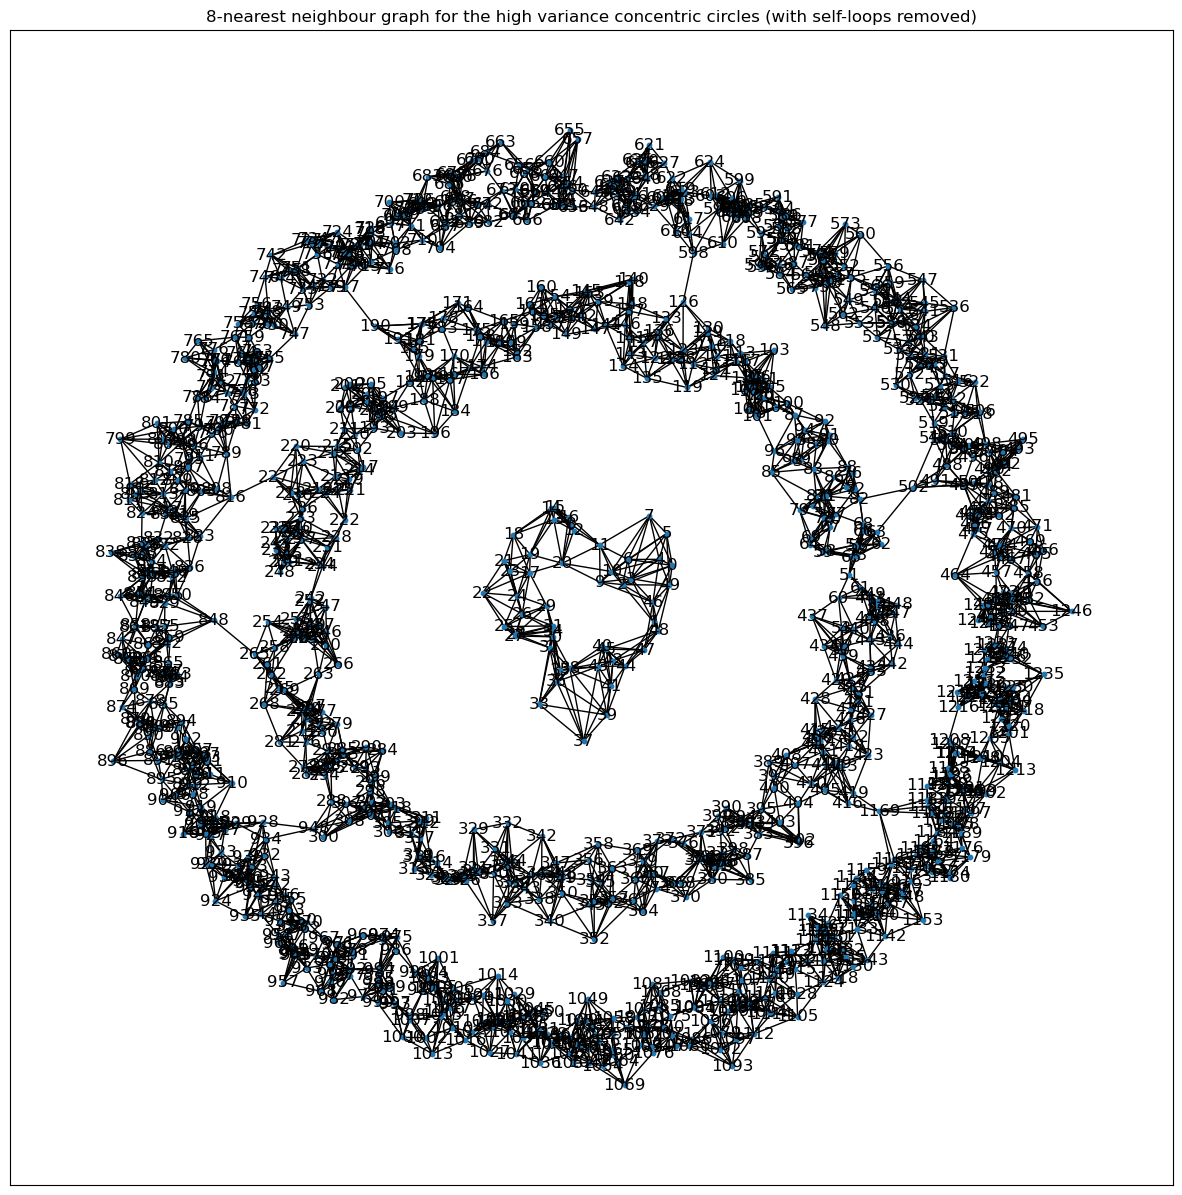

In [8]:
def knn_graph(X, neighbours):
    """
    Args:
        X (np.array, n x p):  data points
        neighbours (int): number of nearest neighbours to be considered for each node
    
    Returns:
        A (np.array, n x n): the adjacency matrix of the knn graph
    """    
    
    n = X.shape[0]
    A = np.zeros((n,n))
    
    for i in range(n) :
        dist = np.linalg.norm(X - X[i, :], axis=1)
        arg = np.argsort(dist)
        A[i, arg[:neighbours]] = 1
        A[arg[:neighbours], i] = 1
        
    return A


def gaussianKernel(X1, X2, sigma = 0.1):
    """
    Args:
        X1 (np.array, n_1 x p): a set of n_1 datapoints to be used as the first of the two kernel inputs
        X2 (np.array, n_2 x p): a set of n_2 datapoints to be used as the second of the two kernel inputs
    
    Returns:
        K (np.array, n_1 x n_2): a kernel matrix containing the kernel values measuring of all possible data point pairs
    """    
    K = np.zeros((X1.shape[0],X2.shape[0]))
     
    for i in range(X1.shape[0]) :
        K[i, :] =  np.exp(-np.linalg.norm(X1[i, :]-X2, axis=1)**2 / (2 * sigma **2))
    
    
    return K


A_low_var_Gaus = gaussianKernel(X_low_var, X_low_var)
A_high_var_Gaus = gaussianKernel(X_high_var, X_high_var)


neighbours = 8
A_low_var_knn = knn_graph(X_low_var, neighbours)
A_high_var_knn =  knn_graph(X_high_var, neighbours)


    
plt.figure(1, figsize=(15,15))
G_high_var = nx.from_numpy_array(A_high_var_knn-np.eye(A_high_var_knn.shape[0]))
nx.draw_networkx(G_high_var, pos=X_high_var, node_size=10)
plt.title("%d-nearest neighbour graph for the high variance concentric circles (with self-loops removed)" %(neighbours))
plt.show()

We now briefly review the spectral clustering algorithm. For more detail on this algorithm please revisit the slides from lecture 3 or take a look at this [fantastic paper](https://arxiv.org/pdf/0711.0189.pdf).

In the spectral clustering algorithm we utilise the spectral decomposition of a graph representation matrix such as the random walk Laplacian $L_{rw} = I - D^{-1}A$ to cluster a graph or network. Specifically, the spectral clustering algorithm consists of two steps. First we compute the spectral decomposition of the used graph representation matrix,
$$
L_{rw} = U \Lambda U^T.
$$
Then, in the second step we run the $k$-means algorithm on the rows of the eigenvector matrix $U_k,$ containing the eigenvectors corresponding to the $k$ smallest eigenvalues of $L_{rw},$ to cluster the nodes in our graph.

If instead of a graph we only have a set of datapoints then we are still able to use the spectral clustering algorithm by utilising one of several heuristics to infer a graph from the dataset. One such method produces a weighted *fully connected graph by using the Gaussian kernel* to represent edge weights in our inferred graph. Another is to infer a $k$*-nearest neighbours graph*, where two nodes are connected if either of them are in within the $k$ nearest neighbours of the other in Euclidean distance.



>**Task 6:** Implement the spectral clustering algorithm and use it to cluster the four graphs obtained in Task 5.

c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\ziado\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

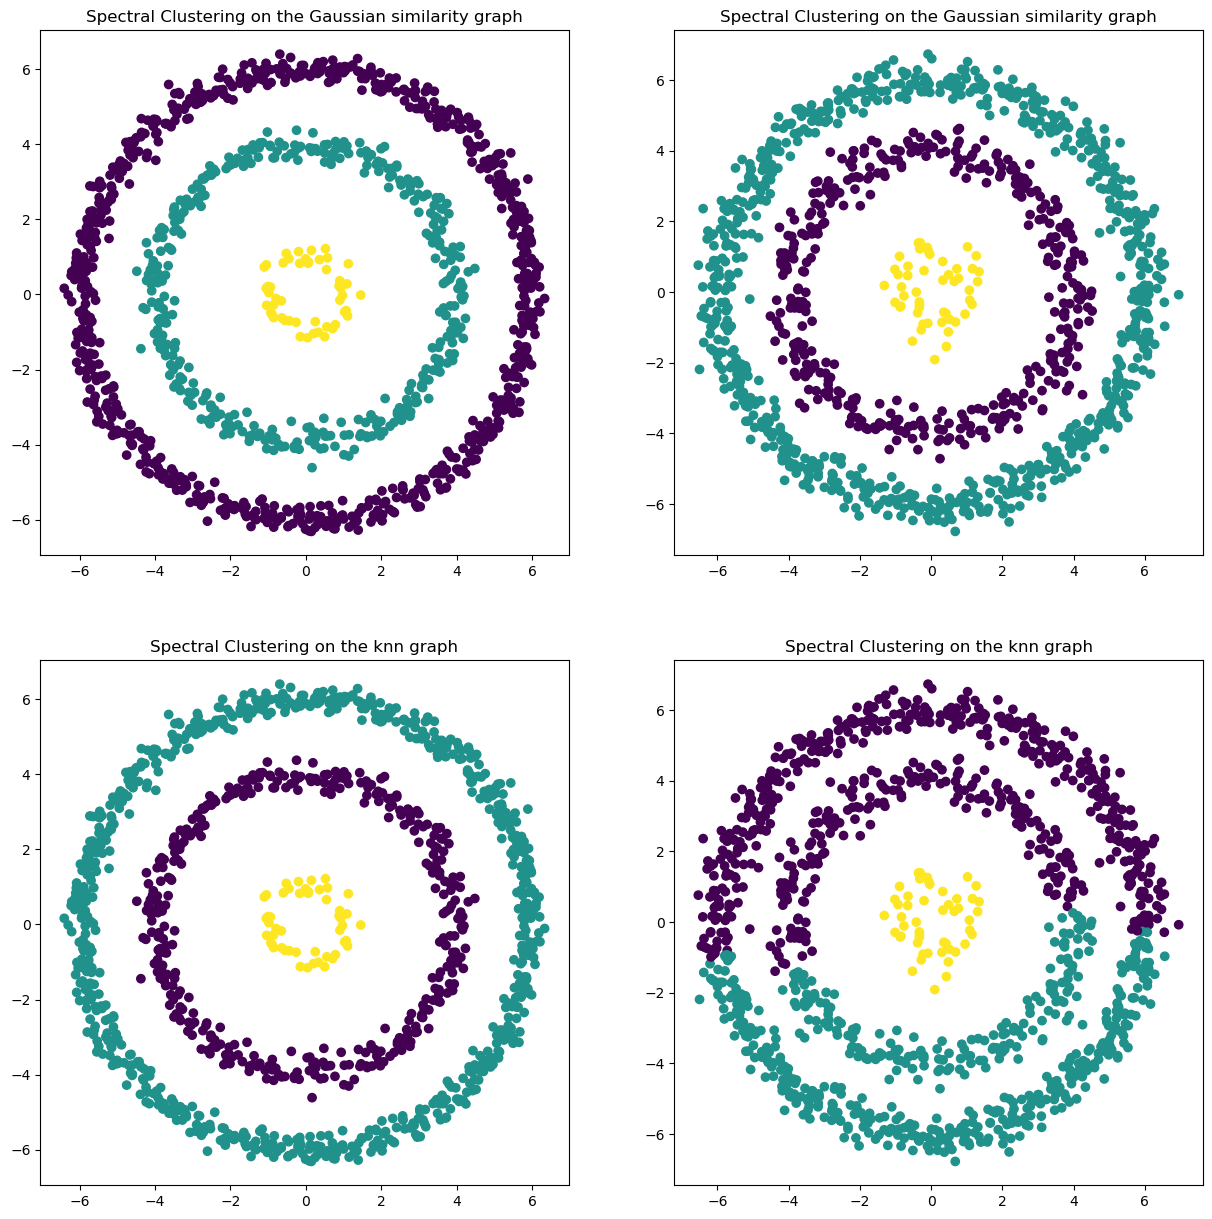

In [20]:
def spectral_clustering(A,k):
    """
    Args:
        A (np.array, n x n): the adjacency matrix of our graph
        k (int): the number of clusters
    
    Returns:
        classes (np.array, n): the inferred class labels of the n nodes
        U_k (np.array, nxk): the k eigenvectors used in the 
    """    

    n = A.shape[0]
    D = np.sum(A, axis= 0)
    L = np.eye(n) - np.diag(1 / D) @ A
    U, _ , _ = np.linalg.svd(L)
    
    
    U_k = U[:, n-k:]
    model_kmean = KMeans(n_clusters=3, n_init=10).fit(U_k)
    classes = model_kmean.labels_
    
    return classes, U_k




classes_low_var_Gaus, U_k_low_var_Gaus = spectral_clustering(A_low_var_Gaus,3)
classes_high_var_Gaus, U_k_high_var_Gaus = spectral_clustering(A_high_var_Gaus,3)

classes_low_var_knn, U_k_low_var_knn = spectral_clustering(A_low_var_knn,3)
classes_high_var_knn, U_k_high_var_knn = spectral_clustering(A_high_var_knn,3)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
ax[0,0].scatter(X_low_var[:,0], X_low_var[:,1], c=classes_low_var_Gaus, facecolors="none") 
ax[0,0].title.set_text('Spectral Clustering on the Gaussian similarity graph')

ax[0,1].scatter(X_high_var[:,0], X_high_var[:,1], c=classes_high_var_Gaus, facecolors="none") 
ax[0,1].title.set_text('Spectral Clustering on the Gaussian similarity graph')

ax[1,0].scatter(X_low_var[:,0], X_low_var[:,1], c=classes_low_var_knn, facecolors="none") 
ax[1,0].title.set_text('Spectral Clustering on the knn graph')

ax[1,1].scatter(X_high_var[:,0], X_high_var[:,1], c=classes_high_var_knn, facecolors="none") 
ax[1,1].title.set_text('Spectral Clustering on the knn graph')

plt.show()